<a href="https://colab.research.google.com/github/kimdonggyu2008/deep_daiv_-/blob/main/Week1_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 들어가며


딥러닝을 공부할 때에는 논문을 읽고 이해하는 것도 중요하나 논문에 나온 아이디어를 실제로 구현할 수 있는 것도 중요합니다. 아이디어들은 많은 경우 수학, 통계학적 직관에서 출발하나 딥러닝 연구는 지극히 경험적 (Empirical)입니다. 앞으로 진행할 과제들은 매주 코딩을 간단히 수행하게 되는데, 데이터 수집부터 모델 제작, 학습 및 추론에 이르기까지 전 과정을 매주 구현하는 것은 무리가 있기에 전체 과정을 몇 단계로 나누고 이들 중 일부를 직접 구현해야 합니다. 딥러닝 모델링과 관련한 코딩 단계를 다음과 같이 나누어 보았습니다.

---
1.   **데이터 수집 및 전처리**

먼저 모델 학습에 사용할 데이터를 수집합니다. 데이터는 주로 선행 연구에서 사용한 것을 이용하는 경우가 많으며 상황에 따라 새로운 데이터셋을 탐색할 수도 있습니다. 이후 모델링에 알맞은 방식으로 데이터를 전처리합니다. 정규화나 표준화를 이용할 수도 있으며, 패딩 (padding), 결측치 처리 (imputation), MFCC, Mel 등과 같은 신호처리, 트리밍 (trimming)(자르기) 등 기법을 사용할 수 있습니다.

---
2.   **모델 디자인**

가장 재미있는 부분입니다. (지극히 주관적) CNN, RNN 등부터 시작해서 FCN, Attention, Masking 등 여러 모델링 아이디어를 코드로 구현하는 과정입니다. 딥러닝 프레임워크에서 제공하는 다양한 tool을 활용할 수도, 고전적인 방식을 활용해 코딩할 수도 있습니다.

---
3. **모델 학습**

역시 매우 중요한 부분입니다. 학습 에폭 (epoch), 배치 크기 (batch size) 등 각종 설정을 조율하는 것부터 목적 함수 (objective function)를 설정하고 최적화 방식을 설정할 수 있습니다. 더불어 Gradient Vanishing 을 해결하거나 과적합을 방지하는 아이디어를 제안할 수 있고 다중 GPU인 경우에 병렬학습을 고안할 수 있습니다. 모델 학습 과정에서 teacher-forcing, distillation 등 학습 방법을 제안할 수도 있습니다.


---
4. **추론 및 평가**

추론은 모델에서 가장 중요한 부분 중 하나입니다. 결국 추론을 할 수 있어야 모델을 상용화하고 배포할 수 있습니다. 디코더 기반이라면 loop을 이용해 autoregressive 구조를 제안해야 할 것이며, 분류 모델이었다면 softmax를 hard label로 바꾸어 실제 라벨을 맵핑하는 과정 등이 그 예시입니다.

평가를 위한 지표는 목적 함수와는 다를 수도 있습니다. 모델 성능을 평가하기 위해 시각화, 음성화 등을 이용할 수 있고, 중간 feature extraction을 평가하기 위해 t-SNE 등을 활용하기도 합니다. 사람들에게 설문조사를 통해 모델의 성능을 비교할 수도 있습니다. 또한 모델의 효율성을 평가하기 위해 MACs, FLOPs 등을 이용해 연산복잡도를 측정할 수도 있습니다.

---

5. **기타**

위의 과정 이외에도 여타 라이브러리를 이용해 모델 학습을 효율화하거나 모델링을 더 쉽게 만드는 여러 방법을 제안할 수 있습니다.



*과제의 많은 문제들은 정답이 없는 경우가 많습니다.*

# HW 1. Design a Model that does not need positional embedding in AST, compare performance with AST without pretraining.

과제 목표: 모델 디자인, 모델 학습, 모델 추론 코드를 작성할 수 있다.

# HW 2. Test if different ‘patchify’ system does help training process converge better in AST

# 제반 작업

In [26]:
from google.colab import drive
from google.colab import output
drive.mount("/content/gdrive")
import sys
!pip install fvcore #컴퓨터 비전용
!pip install timm #이미지 모델이 포함된 라이브러리
!pip install torchinfo #pytorch의 모델 요약정보를 출력할때 사용
!pip install python_speech_features # 음성신호 처리에 필요한 기능들
!pip install wget #웹에서 파일 가져오기
output.clear()
!pip install wandb

In [27]:
!wandb login 513a1f0c050fa7f60a76b5232e904d8df397082e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
import os
import timm
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
import os
import timm
from timm.models.layers import to_2tuple,trunc_normal_
import wget
import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
from sklearn.utils.class_weight import compute_class_weight
from fvcore.nn import parameter_count_table
from torchinfo import summary
import pickle
import einops
import torch.autograd as autograd
import wandb

# Preprocessing(전처리)

In [29]:
"""
Data Description

https://www.kaggle.com/c/freesound-audio-tagging/data

다양한 악기, 동물소리, 사람 소리 등이 라벨과 함께 주어진 데이터
"""

'\nData Description\n\nhttps://www.kaggle.com/c/freesound-audio-tagging/data\n\n다양한 악기, 동물소리, 사람 소리 등이 라벨과 함께 주어진 데이터\n'

엔벨롭 함수(게이트) - 임계치 이하 에너지는 무시하고 나머지만 남김


In [30]:
def envelope(y, rate, threshold): #각 마스크별 유효값 확인(게이트 함수)
  mask = []
  y = pd.Series(y).apply(np.abs)  # make y absolute value
  y_mean = y.rolling(window = int((rate/10)), min_periods = 1, center = True).mean()#??
  for mean in y_mean: #각 윈도우의 평균이 임계값이 넘는지 확인하고 추가
    if mean > threshold:
      mask.append(True)
    else:
      mask.append(False)

  return mask


def normalize_mel(S, min_level_db = -100): #정규화
    return np.clip((S-min_level_db)/-min_level_db, 0,1)

In [31]:
"""
m_path = "/content/gdrive/MyDrive/Audio Classification/audio_train" # 수정
df = pd.read_csv("/content/gdrive/MyDrive/Audio Classification/real_df.csv") # 수정
df.set_index("fname", inplace = True) #fname을 기준으로 인덱스 지정

if len(os.listdir("/content/gdrive/MyDrive/Audio Classification/clean")) == 0:
  for f in tqdm(df.fname):#데이터프레임의 파일 이름별로 읽어옴
    signal, rate = librosa.load(os.path.join(m_path, f), sr = 16000)
    mask = envelope(signal, rate, 0.0005)
    wavfile.write(filename = "/content/gdrive/MyDrive/Audio Classification/clean/"+f, rate = rate, data = signal[mask])
#파일이름, 16000 샘플링레이트, 시그널 중 true인 값만 남긴 데이터로만 구성됨
"""


'\nm_path = "/content/gdrive/MyDrive/Audio Classification/audio_train" # 수정\ndf = pd.read_csv("/content/gdrive/MyDrive/Audio Classification/real_df.csv") # 수정\ndf.set_index("fname", inplace = True) #fname을 기준으로 인덱스 지정\n\nif len(os.listdir("/content/gdrive/MyDrive/Audio Classification/clean")) == 0:\n  for f in tqdm(df.fname):#데이터프레임의 파일 이름별로 읽어옴\n    signal, rate = librosa.load(os.path.join(m_path, f), sr = 16000)\n    mask = envelope(signal, rate, 0.0005)\n    wavfile.write(filename = "/content/gdrive/MyDrive/Audio Classification/clean/"+f, rate = rate, data = signal[mask])\n#파일이름, 16000 샘플링레이트, 시그널 중 true인 값만 남긴 데이터로만 구성됨\n'

랜덤으로 정해진 샘플의

랜덤한 위치의 멜스펙트로그램과

라벨을 npy파일로 저장함

In [32]:
"""
classes = df["label"].unique() #안겹치게 라벨들 가져옴, numpy배열
class_dist = df.groupby(["label"])["length"].mean() #각 라벨별 길이평균, Mean duration for every class ex: saxophone = 3.2 ...
n_samples = 3 * int(df["length"].sum()/10)  # 샘플링 할 갯수 계산(?) how many times in sampling.
prob_dist = class_dist/class_dist.sum() #각 라벨별 샘플링될 확률, sampling probability proportional to n_samples
step = int(128*99) #약 0.7초용 스텝갯수 sampling for about 0.7 seconds.
"""

'\nclasses = df["label"].unique() #안겹치게 라벨들 가져옴, numpy배열\nclass_dist = df.groupby(["label"])["length"].mean() #각 라벨별 길이평균, Mean duration for every class ex: saxophone = 3.2 ...\nn_samples = 3 * int(df["length"].sum()/10)  # 샘플링 할 갯수 계산(?) how many times in sampling.\nprob_dist = class_dist/class_dist.sum() #각 라벨별 샘플링될 확률, sampling probability proportional to n_samples\nstep = int(128*99) #약 0.7초용 스텝갯수 sampling for about 0.7 seconds.\n'

In [33]:
"""
def build_rand_feat():
  random.seed(1229)
  X = []
  labels = []
  _min, _max = float("inf"), -float("inf")# 최대 최소
  for _ in tqdm(range(n_samples)):#샘플 갯수 만큼 반복
    rand_class = np.random.choice(class_dist.index, p = prob_dist) #랜덤하게 하나 가져옴
    file = np.random.choice(df[df.label == rand_class].index)  # RandomSample a file in the class category
    try: #랜덤한 샘플 가져오기

      wav, sr = librosa.load("/content/gdrive/MyDrive/Audio Classification/clean/"+file, sr = 16000)
      #가져와지는 wav는 numpy2차원 배열
      label = str(df.at[file, "label"]) # sampled instrument
    except:
      print("can't read file; moving onto next file")
      continue
    try:#랜덤한 샘플의 랜덤한 위치 가져오기

      rand_index = np.random.randint(0, wav.shape[0]-step)# 스텝이 int라 위치도 int로 가져옴
      sample = wav[rand_index:rand_index+step] # sample for about 0.7 seconds

      X_sample = librosa.feature.melspectrogram(y = sample, sr = sr, n_fft = 1024, hop_length = 128, n_mels = 128)#데이터 추출
      X_sample = normalize_mel(librosa.power_to_db(X_sample, ref = np.max)) # 파워 멜스펙트로그램 Normalized Log Mel Spectrogram
      X.append(X_sample)
      label = np.where(classes == label)[0][0]
      labels.append(label)

    except:

      continue

  return X, labels
  """

'\ndef build_rand_feat():\n  random.seed(1229)\n  X = []\n  labels = []\n  _min, _max = float("inf"), -float("inf")# 최대 최소\n  for _ in tqdm(range(n_samples)):#샘플 갯수 만큼 반복\n    rand_class = np.random.choice(class_dist.index, p = prob_dist) #랜덤하게 하나 가져옴\n    file = np.random.choice(df[df.label == rand_class].index)  # RandomSample a file in the class category\n    try: #랜덤한 샘플 가져오기\n\n      wav, sr = librosa.load("/content/gdrive/MyDrive/Audio Classification/clean/"+file, sr = 16000)\n      #가져와지는 wav는 numpy2차원 배열\n      label = str(df.at[file, "label"]) # sampled instrument\n    except:\n      print("can\'t read file; moving onto next file")\n      continue\n    try:#랜덤한 샘플의 랜덤한 위치 가져오기\n\n      rand_index = np.random.randint(0, wav.shape[0]-step)# 스텝이 int라 위치도 int로 가져옴\n      sample = wav[rand_index:rand_index+step] # sample for about 0.7 seconds\n\n      X_sample = librosa.feature.melspectrogram(y = sample, sr = sr, n_fft = 1024, hop_length = 128, n_mels = 128)#데이터 추출\n      X_sample 

In [34]:
"""
X, y = build_rand_feat() #랜덤한 요소 멜스펙트로그램, 라벨 저장
X = np.array(X)
y = np.array(y)

np.save("/content/gdrive/MyDrive/코딩공부/deep_daiv/dataset/Xmel_torch.npy", X)
np.save("/content/gdrive/MyDrive/코딩공부/deep_daiv/dataset/ymel_torch.npy", y)
"""

'\nX, y = build_rand_feat() #랜덤한 요소 멜스펙트로그램, 라벨 저장\nX = np.array(X)\ny = np.array(y)\n\nnp.save("/content/gdrive/MyDrive/코딩공부/deep_daiv/dataset/Xmel_torch.npy", X)\nnp.save("/content/gdrive/MyDrive/코딩공부/deep_daiv/dataset/ymel_torch.npy", y)\n'

# Dataset

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
# 경로 설정 필요

X = np.load("/content/gdrive/MyDrive/코딩공부/deep_daiv/dataset/Xmel_torch.npy", allow_pickle = True) # 데이터 수, 멜주파수 대역 갯수, 시간축 길이(#data, #mel_bins, #time bins)
y = np.load("/content/gdrive/MyDrive/코딩공부/deep_daiv/dataset/ymel_torch.npy") # 각 파일의 라벨(#data, )

각 라벨에 대해서 원핫 인코딩

해당 인코딩을 통해

In [37]:
num_classes = 41

y = np.eye(num_classes)[y] # 각 데이터에 대해 대각행렬 적용, 한마디로 각각 1을 가지는 위치가 생김One-hot-encoder

print(X.shape, y.shape)
#데이터 갯수, 멜스펙트로그램 대역 갯수, 시간축 길이(100으로 나눔)
#데이터 갯수, 각 라벨에 대한 원핫 인코딩 값

(16745, 128, 100) (16745, 41)


오디오 데이터셋 선언


In [38]:
class audio_dataset(Dataset):
    def __init__(self, X_data, y_data):

        #데이터셋으로 묶음
        self.X_data = X_data #(#data, #coefs, #timetsteps)
        self.y_data = y_data #(#data, #labels)
        #플로트 텐서화
        self.X_torch = torch.FloatTensor(self.X_data).to(device) #(#data, #coefs, #timetsteps)
        self.y_torch = torch.FloatTensor(self.y_data).to(device) #(#data, #labels)
        #길이, 샘플 갯수 추출
        self.x_len = self.X_torch.shape[0]
        self.y_len = self.y_torch.shape[0]
        #조건여부 확인
        assert self.x_len == self.y_len

    def __getitem__(self, index):
        return self.X_torch[index], self.y_torch[index] #x=인덱스값의 데이터, 주파수 대역, 시간 반환, y=인덱스 값의 데이터, 라벨 원핫 반환
    def __len__(self): #데이터 갯수 반환
        return self.x_len

MULTI-HEAD-ATTENTION


I


V


MLP, POOLING

# Model

In [39]:
def summarize_model(model, input_shape, is_cuda = False): #모델 확인
  global device

  if is_cuda: #gpu여부 확인
    x = torch.rand(input_shape).to(device)
  else:
    x = torch.rand(input_shape)
  print(parameter_count_table(model))

  print(summary(model, input_size = input_shape))

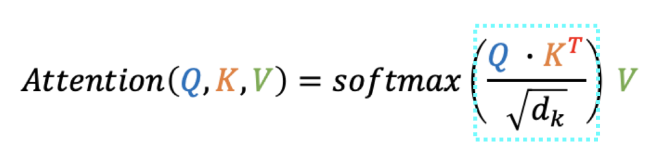

In [40]:
class MultiHeadAttention(nn.Module):
  # [Batch_size, sequence_length, emb_size], 나눠진 데이터 값들, 각 데이터 길이,
    def __init__(self, emb_size = 384, num_heads = 6, dropout = 0):
        super().__init__()
        self.emb_size = emb_size #변형할 데이터의 차원
        self.num_heads = num_heads #멀티헤드 어텐션의 헤드 수
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3) #[배치 사이즈, 시퀀스 길이, emb_size*3]형태
        self.att_drop = nn.Dropout(dropout) #드롭아웃 지정
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x):

      #x.shape = [batch_size, num_patches, embed_dim]

        # split keys, queries and values in num_heads
        qkv = einops.rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        #차원 형태 변경, [3,배치 사이즈, num_heads, 헤드 디멘션(6)]으로 변경
        queries, keys, values = qkv[0], qkv[1], qkv[2] #각각 똑같은 형태의 차원으로 나눔
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        #배치, 헤드, 쿼리, 헤드 차원 과 배치, 헤드, 키, 헤드 차원 -> 배치, 헤드, 쿼리길이,  키 길이
        scaling = self.emb_size ** (1/2)
        #어텐션 계산

        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = einops.rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [41]:
class Pooling(nn.Module):
  def __init__(self,pool_size=3):
    super().__init__()
    self.pool=nn.AvgPool2d(
        pool_size,stride=1,padding=pool_size//2,count_include_pad=False)

  def forward(self,x):
    return self.pool(x)-x

In [42]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_size=384, num_heads=8, dropout=0.1, forward_expansion=2,pool_size=3):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(emb_size) #정규화 레이어 2개
        self.norm2 = nn.LayerNorm(emb_size)
        self.token_mixer=Pooling(pool_size=pool_size) #수정부분
        self.feed_forward = nn.Sequential( #순서 지정
            nn.Linear(emb_size, forward_expansion * emb_size),
            nn.GELU(),
            nn.Linear(forward_expansion * emb_size, emb_size),
            nn.Dropout(dropout),
        )

    def forward(self, x): #x는 배치사이즈, emb_size, 시퀸스 길이

        x=+x+self.token_mixer(self.norm1(x)) #수정부분
        x=x+self.feed_forward(self.norm2(x))

        return x # Input shape and Output Shape are the same.

In [43]:
class AST(nn.Module):
    """
    label_dim: the number of total classes, 41
    fstride: the stride of patch spliting on the frequency dimension, int
    tstride: the stride of patch spliting on the time dimension
    input_fdim: # frequency bins of the input spectrogram
    input_tdim: # time frames of the input spectrogram
    embed_dim : # embed_dimensions of ViT
    """
    def __init__(self, label_dim=41, fstride=10, tstride=10, input_fdim=128, input_tdim=100, embed_dim = 384, num_heads = 6, n_blocks = 12, verbose=True):

        super(AST, self).__init__()

        self.label_dim = label_dim
        self.fstride = fstride
        self.tstride = tstride
        self.input_fdim = input_fdim
        self.input_tdim = input_tdim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.n_blocks = n_blocks


        if verbose == True:
            print('---------------AST Model Initializing---------------')



        self.patch_embedding = nn.Conv2d(in_channels = 1, out_channels = self.embed_dim, kernel_size = 16, stride = (self.fstride, self.tstride))
        #주어진 범위를 클래스 토큰으로 지정
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))
        #모델로 사용할 텐서를 랜덤으로 지정
        self.patch_embedding.apply(self.init_weights)

        #가중치 추기화
        f_dim, t_dim = self.get_shape(fstride = self.fstride, tstride = self.tstride,
                       input_fdim = self.input_fdim, input_tdim = self.input_tdim)
        num_patches = f_dim * t_dim
        #입력 데이터 크기, 스트라이드 기반 패치 갯수 계산
        #self.position_embeddings = nn.Parameter(torch.randn(num_patches + 1, self.embed_dim))


        self.blocks = nn.ModuleList() # Transformer block 만들기.
        for _ in range(self.n_blocks): #트랜스포머 블록 갯수만큼 돌기
          self.blocks.append(TransformerBlock(self.embed_dim, self.num_heads)) #int,


        self.norm = nn.LayerNorm(self.embed_dim)
        self.mlp_head = nn.Sequential(nn.LayerNorm(self.embed_dim), nn.Linear(self.embed_dim, self.label_dim))


        if verbose == True:

            print('frequency stride={:d}, time stride={:d}'.format(self.fstride, self.tstride))
            print('number of patches={:d}'.format(num_patches))



    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=100):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.embed_dim, kernel_size=16, stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    def init_weights(self, m, mean = 0.0, std = 0.01):
      classname = m.__class__.__name__
      if classname.find("Conv") != -1: # if module == Conv
        m.weight.data.normal_(mean,std) #Initialize weights

    @autocast() #Speed up Training
    def forward(self, x):
        """
        x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        return: prediction
        """
        # expect input x = (batch_size, frequency bins, time bins), e.g., (16, 128, 100)
        x = x.unsqueeze(1) # (batch_size, 1, frequency bins, time bins), e.g., (16, 1, 128, 100)

        B = x.shape[0]
        x = self.patch_embedding(x) # (batch_size, #embed_dim, f_dim, t_dim)
        x = x.flatten(2) # (batch_size, #embed_dim, num_patches)
        x = x.transpose(1, 2) #(batch_size, num_patches, #embed_dim)

        #여긴 모양 동일?
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, #embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches + 1, #embed_dim)
        #??
        #x = x + self.position_embeddings #(B, num_patches + 1, #embed_dim)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2 # (B, 1, #embed dim).

        x = self.mlp_head(x) # Why no Softmax in the end? https://slamwithme.oopy.io/305bb7e0-1062-4785-a82e-9e2a5debd0f4
        #소프트맥스가 없네? 뭐로 구별하는거지
        return x

In [44]:
# 7 M parameters

ast = AST(num_heads = 3, n_blocks = 6).to(device)
summarize_model(ast, [16, 100, 128], is_cuda = True) #[Batch_size, sequence_length, emb_size]

---------------AST Model Initializing---------------
frequency stride=10, time stride=10
number of patches=108
| name                     | #elements or shape   |
|:-------------------------|:---------------------|
| model                    | 3.7M                 |
|  cls_token               |  (1, 1, 384)         |
|  patch_embedding         |  98.7K               |
|   patch_embedding.weight |   (384, 1, 16, 16)   |
|   patch_embedding.bias   |   (384,)             |
|  blocks                  |  3.6M                |
|   blocks.0               |   0.6M               |
|    blocks.0.norm1        |    0.8K              |
|    blocks.0.norm2        |    0.8K              |
|    blocks.0.feed_forward |    0.6M              |
|   blocks.1               |   0.6M               |
|    blocks.1.norm1        |    0.8K              |
|    blocks.1.norm2        |    0.8K              |
|    blocks.1.feed_forward |    0.6M              |
|   blocks.2               |   0.6M               |
|    

# Training

In [45]:
CONFIG = {
    'lr': 0.0002,
    'epochs': 30,
    'min_batch': 16,
    'weight_decay': 1e-4, # optional, TBD
    "save_path": "/content/gdrive/MyDrive/코딩공부/deep_daiv/results"
}

In [46]:
X_len = X.shape[0] #데이터 갯수
train_size = 0.8 #학습데이터 비율
idx = np.random.permutation(X_len) #데이터를 섞어서 학습, 테스트가 랜덤하게 선택됨
#학습데이터, 테스트 데이터 인덱스
train_idx = idx[:round(train_size*X_len)]; test_idx = idx[round(train_size*X_len):]
#학습 데이터, 테스트 데이터를 인덱스에 따라 추출
X_train = X[train_idx].astype(np.float32); X_test = X[test_idx].astype(np.float32);
#골라진 학습데이터, 테스트 데이터의 레이블 추출
y_train = y[train_idx].astype(np.float32); y_test = y[test_idx].astype(np.float32) ;

#데이터셋, 레이블 묶음
audio_train = audio_dataset(X_train, y_train)
audio_test = audio_dataset(X_test, y_test)

#묶인 데이터들 읽어옴
train_loader = DataLoader(audio_train, batch_size = CONFIG["min_batch"], shuffle = True)
test_loader = DataLoader(audio_test, batch_size = CONFIG["min_batch"], shuffle = True)

In [47]:
model = AST(num_heads = 3, n_blocks = 6).to(device)
criterion = nn.CrossEntropyLoss() #크로스 엔트로피로 확인
optimizer = optim.Adam(model.parameters(), lr = CONFIG["lr"])

loss_history = []
val_loss_history = []
init_loss = 991229 # Random high number

---------------AST Model Initializing---------------
frequency stride=10, time stride=10
number of patches=108


In [48]:
wandb.init(
    project="ast transformer",
    config={
        "learning_rate":0.0002,
        "architecture":"transformer",
        "dataset":"ast",
        "epochs":30,
        'weight_decay': 1e-4,
    }
)

In [49]:
print("Initializing training...") #학습 시작
torch.manual_seed(1229)


for epoch in tqdm(range(CONFIG["epochs"])): #에폭 횟수만큼
  print(f"\n Epoch {epoch}...")
  run_loss = 0.0

  for i, data in enumerate(train_loader):

    #학습 시퀀스
    inputs, labels = data #샘플 갯수, 라벨 분리
    optimizer.zero_grad() #초기화
    outputs = model(inputs) #모델에 넣음

    loss = criterion(outputs, labels)#확인

    loss.backward()#역전파
    optimizer.step()
    run_loss += loss.item()


    #평가 시퀀스
    if i % 500 == 499: #1번이 붙은 횟수 마다 반복
      loss_history.append(run_loss/500)
      wandb.log({"loss": loss})
      print(f'[{epoch +1}, {i + 1:5d}] loss : {run_loss/500:.3f}')
      run_loss = 0.0

      with torch.no_grad(): #그래디언트 계산 안함
          val_loss = 0.0
          for k, (val_inputs, val_labels) in enumerate(test_loader):
              val_output = model(val_inputs)
              v_loss = criterion(val_output, val_labels) #예측과 실제값 비교, 출력은 스칼라값
              val_loss += v_loss
          print(f'[{epoch + 1}, {i + 1:5d}] val loss: {val_loss / k:.3f}')
          wandb.log({"val loss": val_loss})
          val_loss_history.append(val_loss.item()/500)

      if val_loss < init_loss: #더 좋으면 업데이트
          torch.save(model, os.path.join(CONFIG["save_path"], 'ast.pt'))

          init_loss = val_loss
wandb.finish()
print("finished training ...")



Initializing training...


  0%|          | 0/30 [00:00<?, ?it/s]


 Epoch 0...
[1,   500] loss : 3.433
[1,   500] val loss: 3.304


  3%|▎         | 1/30 [00:12<06:16, 12.98s/it]


 Epoch 1...
[2,   500] loss : 3.171
[2,   500] val loss: 3.042


  7%|▋         | 2/30 [00:23<05:21, 11.49s/it]


 Epoch 2...
[3,   500] loss : 2.993
[3,   500] val loss: 3.074


 10%|█         | 3/30 [00:33<04:50, 10.75s/it]


 Epoch 3...
[4,   500] loss : 2.905
[4,   500] val loss: 2.918


 13%|█▎        | 4/30 [00:43<04:30, 10.39s/it]


 Epoch 4...
[5,   500] loss : 2.832
[5,   500] val loss: 2.831


 17%|█▋        | 5/30 [00:53<04:18, 10.34s/it]


 Epoch 5...
[6,   500] loss : 2.800
[6,   500] val loss: 2.790


 20%|██        | 6/30 [01:03<04:08, 10.35s/it]


 Epoch 6...
[7,   500] loss : 2.729
[7,   500] val loss: 2.817


 23%|██▎       | 7/30 [01:13<03:51, 10.09s/it]


 Epoch 7...
[8,   500] loss : 2.717
[8,   500] val loss: 2.740


 27%|██▋       | 8/30 [01:24<03:46, 10.30s/it]


 Epoch 8...
[9,   500] loss : 2.617
[9,   500] val loss: 2.640


 30%|███       | 9/30 [01:34<03:36, 10.31s/it]


 Epoch 9...
[10,   500] loss : 2.543
[10,   500] val loss: 2.635


 33%|███▎      | 10/30 [01:49<03:54, 11.72s/it]


 Epoch 10...
[11,   500] loss : 2.478
[11,   500] val loss: 2.555


 37%|███▋      | 11/30 [01:59<03:34, 11.31s/it]


 Epoch 11...
[12,   500] loss : 2.418
[12,   500] val loss: 2.462


 40%|████      | 12/30 [02:09<03:15, 10.86s/it]


 Epoch 12...
[13,   500] loss : 2.332
[13,   500] val loss: 2.474


 43%|████▎     | 13/30 [02:19<02:59, 10.53s/it]


 Epoch 13...
[14,   500] loss : 2.249
[14,   500] val loss: 2.459


 47%|████▋     | 14/30 [02:29<02:46, 10.43s/it]


 Epoch 14...
[15,   500] loss : 2.161
[15,   500] val loss: 2.375


 50%|█████     | 15/30 [02:39<02:36, 10.42s/it]


 Epoch 15...
[16,   500] loss : 2.116
[16,   500] val loss: 2.408


 53%|█████▎    | 16/30 [02:50<02:25, 10.41s/it]


 Epoch 16...
[17,   500] loss : 2.011
[17,   500] val loss: 2.368


 57%|█████▋    | 17/30 [02:59<02:12, 10.21s/it]


 Epoch 17...
[18,   500] loss : 1.949
[18,   500] val loss: 2.306


 60%|██████    | 18/30 [03:10<02:02, 10.21s/it]


 Epoch 18...
[19,   500] loss : 1.860
[19,   500] val loss: 2.369


 63%|██████▎   | 19/30 [03:20<01:52, 10.25s/it]


 Epoch 19...
[20,   500] loss : 1.777
[20,   500] val loss: 2.310


 67%|██████▋   | 20/30 [03:30<01:41, 10.16s/it]


 Epoch 20...
[21,   500] loss : 1.689
[21,   500] val loss: 2.283


 70%|███████   | 21/30 [03:40<01:30, 10.06s/it]


 Epoch 21...
[22,   500] loss : 1.603
[22,   500] val loss: 2.373


 73%|███████▎  | 22/30 [03:50<01:20, 10.11s/it]


 Epoch 22...
[23,   500] loss : 1.519
[23,   500] val loss: 2.378


 77%|███████▋  | 23/30 [04:00<01:10, 10.12s/it]


 Epoch 23...
[24,   500] loss : 1.476
[24,   500] val loss: 2.382


 80%|████████  | 24/30 [04:10<00:59,  9.91s/it]


 Epoch 24...
[25,   500] loss : 1.378
[25,   500] val loss: 2.328


 83%|████████▎ | 25/30 [04:19<00:49,  9.91s/it]


 Epoch 25...
[26,   500] loss : 1.286
[26,   500] val loss: 2.361


 87%|████████▋ | 26/30 [04:30<00:39,  9.98s/it]


 Epoch 26...
[27,   500] loss : 1.221
[27,   500] val loss: 2.358


 90%|█████████ | 27/30 [04:40<00:30, 10.03s/it]


 Epoch 27...
[28,   500] loss : 1.193
[28,   500] val loss: 2.399


 93%|█████████▎| 28/30 [04:49<00:19,  9.82s/it]


 Epoch 28...
[29,   500] loss : 1.101
[29,   500] val loss: 2.493


 97%|█████████▋| 29/30 [04:59<00:09,  9.90s/it]


 Epoch 29...
[30,   500] loss : 1.062
[30,   500] val loss: 2.656


100%|██████████| 30/30 [05:09<00:00, 10.33s/it]


loss,▇██▆▇▅▆▇▆▇▄▆▆▄▄▄▃▃▆▃▄▃▃▄▂▁▃▁▁▁
val loss,█▆▆▅▅▄▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▂▂▂▁▂▂▂▂▄
loss,0.99176
val loss,555.07642


finished training ...


# Evaluation

In [50]:
def test_model(model, X_test, y_test, device):
  model.eval() #평가모드
  inputs = X_test #앞쪽에서 만든 테스트용 데이터와 라벨
  labels = y_test

  with torch.no_grad():
      inputs = torch.FloatTensor(inputs).to(device)  # (#data, #dim, #timesteps)
      labels = torch.FloatTensor(labels).to(device)  # (#data, #labels)
      utputs = model(inputs)
      preds = torch.argmax(outputs, dim=1)
      labels = torch.argmax(labels)
  return np.array(preds.cpu()), np.array(labels.cpu())
